# Stock Market Prediction
***
## Table of Contents
1. [Introduction](#1-introduction)
1. [Device Agnostic Code](#2-device-agnostic-code)
1. [Loading Dataset](#3-loading-dataset)
1. [Exploratory Data Analysis](#4-exploratory-data-analysis)
1. [Sliding Window Sequences](#5-sliding-window-sequences)
1. [Preparing Dataloaders](#6-preparing-dataloaders)
1. [Recurrent Neural Network (RNN) Architectures](#7-recurrent-neural-network-rnn-architectures)
    - [Long Short-Term Memory (LSTM)](#long-short-term-memory-lstm)
    - [Gated Recurrent Unit (GRU)](#gated-recurrent-unit-gru)
1. [Evaluation Metrics](#8-evaluation-metrics)
    - [Root Mean Squared Error (RMSE)](#root-mean-squared-error-rmse)
    - [Mean Absolute Percentage Error (MAPE)](#mean-absolute-percentage-error-mape)
    - [Symmetric Mean Absolute Percentage Error (sMAPE)](#symmetric-mean-absolute-percentage-error-smape)
1. [Optimiser](#10-optimiser)
1. [Training and Evaluation](#11-training-and-evaluation)
    - [Testing Steps](#testing-steps)
    - [Model Training and Evaluation Pipeline](#model-training-and-evaluation-pipeline)
    - [Performance Evaluation (LSTM)](#performance-evaluation-lstm)
    - [Performance Evaluation (GRU)](#performance-evaluation-gru)
1. [Results](#12-results)
    - [Overall Performance](#overall-performance)
    - [Predictions](#predictions)
    - [Visualising Predictions](#visualising-predictions)
    - [Conclusion (Past Data)](#conclusion-past-data)
1. [Predicting Future Values](#13-predicting-future-values)
    - [Sequence-to-Sequence (Seq2Seq)](#sequence-to-sequence-seq2seq)
    - [DataLoaders for Seq2Seq](#dataloaders-for-seq2seq)
    - [Training Seq2Seq Models](#training-seq2seq-models)
    - [Plotting Future Predictions](#plotting-future-predictions)
    - [Conclusion (Future Prediction)](#conclusion-future-prediction)
1. [References](#14-references)
***

In [ ]:
import torch
import time
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

from datetime import date
from torchinfo import summary
from numpy.typing import NDArray
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

## 1. Introduction
This project aims to illustrate the application of recurrent neural network (RNN) models to time-series forecasting, with a particular focus on stock price data obtained from Yahoo! Finance. The analysis begins by using historical data to compare the predictive performance of two popular RNN variants: the Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU) models. Both architectures are evaluated on their ability to predict historical movements within the training set.

Building on this comparison, the project then extends to forecast the stock’s closing prices for the subsequent five days, thereby providing a practical demonstration of multi-step or Sequence-to-Sequence (Seq2Seq) forecasting in a financial context.

Please note that the forecasts produced in this study are intended solely for learning purposes. The predictions are based exclusively on historical data and model assumptions, and as such, should not be construed as financial advice or recommendations for investment decisions.

## 2. Device Agnostic Code
Mac GPU acceleration (`mps` backend) delivers significant speed-up over CPU for deep learning tasks, especially for large models and batch sizes. On Windows, `cuda` is used instead of `mps`.

However, during the training process, I encountered several issues with LSTM networks on the MPS backend (e.g., error metrics became substantially higher compared to the CPU, etc.). Therefore, the CPU will be used throughout this project for '*safety*'.

**Reference**:
- [Training results from using MPS backend are poor compared to CPU and CUDA](https://github.com/pytorch/pytorch/issues/109457)
- [MPS backend produces bad training results in comparison to other backends](https://github.com/pytorch/pytorch/issues/92615)
- [Memory Leak in MPS Backend During LSTM Iterations (Out of Memory Error)](https://github.com/pytorch/pytorch/issues/145374)

In [2]:
# device = "cuda" if torch.cuda.is_available() else "cpu"  # For Windows
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  # For Mac
device = torch.device("cpu")  # For Mac, safer device use
device

device(type='cpu')

## 3. Loading Dataset
This project will use yfinance API to fetch financial data from Yahoo! Finance. The default DataFrame has a two-level column index: `(column name, ticker)`, so the second level will be removed.

In [3]:
TICKER = "AAPL"  # Apple Inc. stock data
START_DATE = "2015-01-01"
END_DATE = date.today().strftime("%Y-%m-%d")
df = yf.download(TICKER, start=START_DATE, end=END_DATE, auto_adjust=True)
df.columns = df.columns.droplevel(1)  # Drop the second level
df = df.sort_index()

df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,24.288582,24.757336,23.848707,24.746228,212818400
2015-01-05,23.604330,24.137511,23.417718,24.057533,257142000
2015-01-06,23.606556,23.866481,23.244437,23.668760,263188400
2015-01-07,23.937571,24.037541,23.704304,23.815383,160423600
2015-01-08,24.857307,24.915069,24.148621,24.266367,237458000


In [4]:
print("=" * 50)
print(df.head())
print("=" * 50)
print(f"Shape of the dataset: {df.shape}")
print("=" * 50)
print(df.info())
print("=" * 50)
print(f"Count of null values: {df.isnull().sum().sum()}")
print("=" * 50)
print(df.describe())

Price           Close       High        Low       Open     Volume
Date                                                             
2015-01-02  24.288582  24.757336  23.848707  24.746228  212818400
2015-01-05  23.604330  24.137511  23.417718  24.057533  257142000
2015-01-06  23.606556  23.866481  23.244437  23.668760  263188400
2015-01-07  23.937571  24.037541  23.704304  23.815383  160423600
2015-01-08  24.857307  24.915069  24.148621  24.266367  237458000
Shape of the dataset: (2661, 5)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2661 entries, 2015-01-02 to 2025-08-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2661 non-null   float64
 1   High    2661 non-null   float64
 2   Low     2661 non-null   float64
 3   Open    2661 non-null   float64
 4   Volume  2661 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 124.7 KB
None
Count of null values: 0
Price        Close         High          L

In [5]:
FEATURES = list(range(len(df.columns)))  # All features
TARGET_INDEX = df.columns.get_loc("Close") if "Close" in df.columns else 0
TRAIN_SPLIT_RATE = 0.9
SEQUENCE_LENGTH = 90  # 90 days
HORIZON_PAST = 1
HORIZON_FUTURE = 5
BATCH_SIZE = 128
HIDDEN_SIZE = 256
INPUT_SIZE = len(FEATURES)
OUTPUT_SIZE = 1  # We only predict 'Close'
N_LAYERS = 2
LEARNING_RATE = 0.001
EPOCHS = 10

## 4. Exploratory Data Analysis

In [6]:
def plot_figures(df: pd.DataFrame, ticker: str) -> None:
    """
    Plot dual subfigures of time-series for 'Close' price and 'Volume'.

    Args:
        df: DataFrame containing at least 'Close' and 'Volume' columns, indexed by date.
        ticker: Ticker symbol for the financial asset (used in plot titles).

    Notes:
        First subplot visualises the closing price over time, the second the trade volume.
    """
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 6))
    axes = axes.flatten()

    # 1st plot
    sns.lineplot(df, ax=axes[0], x=df.index, y="Close")
    axes[0].set_title(f"{ticker} - Close Price Over Time")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Close Price in USD ($)")

    # 2nd plot
    sns.lineplot(df, ax=axes[1], x=df.index, y="Volume")
    axes[1].set_title(f"{ticker} - Trade Volume Over Time")
    axes[1].set_xlabel("Date")
    axes[1].set_ylabel("Trade Volume")

    plt.tight_layout()
    plt.show()

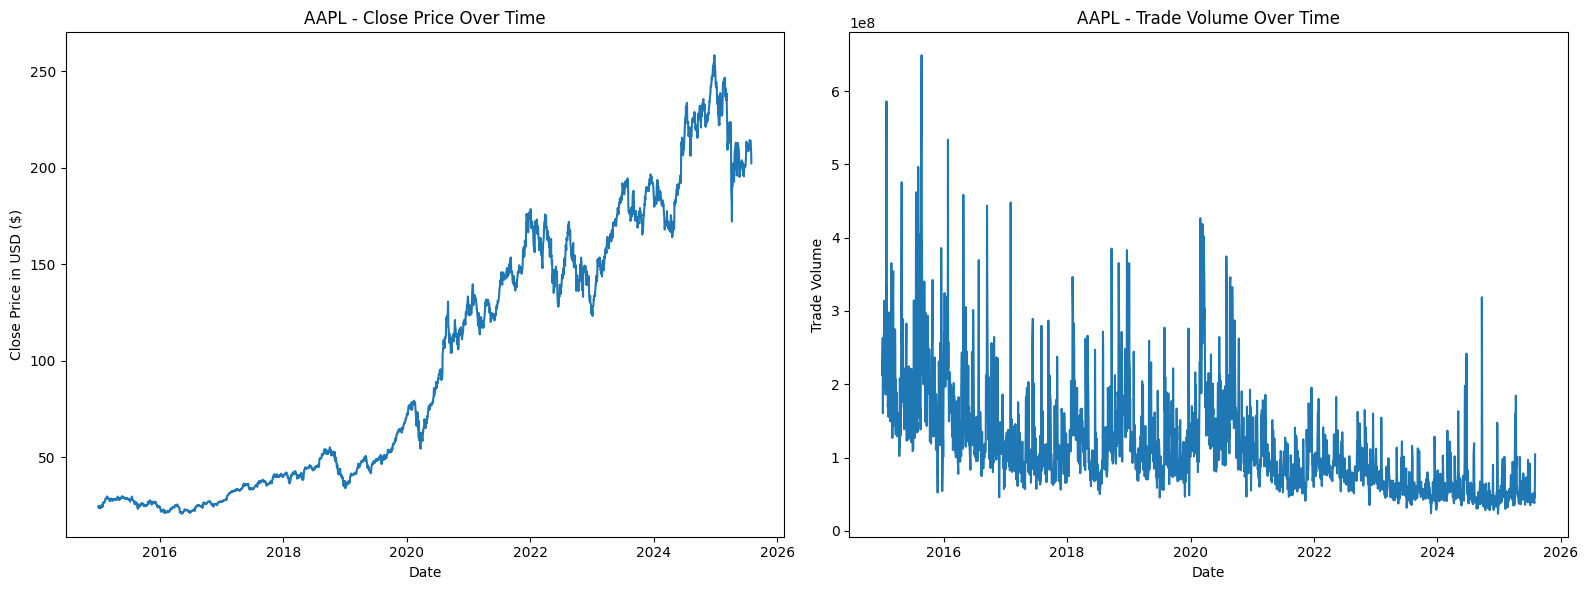

In [7]:
plot_figures(df, TICKER)

## 5. Sliding Window Sequences
The following function generates sliding window sequences and their corresponding targets from a multi-feature time-series array. This is a standard preprocessing step for models such as LSTM, GRU, or other neural networks that require sequence data as input.

<p align="center">
  <img src="https://www.researchgate.net/profile/Bernard-Benson/publication/341502672/figure/fig17/AS:998926190649344@1615173971540/Sliding-window-method-illustrated-with-an-example-sequence-of-numbers-from-1-through-10.ppm" width="550" alt="Sliding window method illustration">
</p>

*Figure: Visualisation of sliding window sequences. Image retrieved from [Forecasting Solar Cycle 25 Using Deep Neural Networks](https://www.researchgate.net/publication/341502672_Forecasting_Solar_Cycle_25_Using_Deep_Neural_Networks).*

By varying the horizon values, we control whether the model predicts just the next step (`horizon=1`) or multiple future steps in one go (`horizon>1`). Increasing the horizon means fewer total training samples but enables multi-step forecasting. This process prepares the data for supervised learning on sequential inputs and their aligned future outputs.

In [ ]:
def create_multistep_sequences(
    data: NDArray[np.float64],
    seq_length: int,
    feature_indices: list[int],
    target_index: int,
    horizon: int = 1,
) -> tuple[NDArray[np.float64], NDArray[np.float64]]:
    """
    Generate overlapping input-output sequence pairs for time-series forecasting.

    Args:
        data: Full time-series numpy array, shape (n_samples, n_features).
        seq_length: Number of time steps in input sequences (historical window size).
        feature_indices: Indices of features to use as input variables.
        target_index: Index of the target variable to be predicted.
        horizon: Number of steps ahead to forecast for each input sequence (forecast horizon).

    Returns:
        A tuple containing:
            - X: Array of input sequences, shape (n_sequences, seq_length, n_features).
            - y: Array of target sequences, shape (n_sequences, horizon, 1).

    Notes:
        For each sliding window, pairs the input sequence with its 'horizon' future targets.
        When horizon > 1, the function enables direct sequence-to-sequence (multi-step) learning.
    """
    n_features, n_samples = len(feature_indices), len(data)
    n_out = n_samples - seq_length - horizon + 1
    X = np.zeros((n_out, seq_length, n_features))
    y = np.zeros((n_out, horizon, 1))
    for i in range(n_out):
        X[i] = data[i : i + seq_length, feature_indices]
        y[i] = data[i + seq_length : i + seq_length + horizon, target_index].reshape(
            -1, 1
        )
    print(f"n_samples: {n_samples}\nX.shape: {X.shape} | y.shape: {y.shape}")
    return X, y

## 6. Preparing Dataloaders
1. Split data chronologically
2. Standardise data
3. Create sliding window sequences with targets for train/test datasets
4. Convert subsets to PyTorch tensors then to dataloaders
5. Return dataloaders & scalers (for inverse transformation later)

In [ ]:
def prepare_dataloaders(
    df: pd.DataFrame,
    seq_length: int,
    horizon: int,
    input_features: list[int] | None,
    target_index: int,
    train_split: float,
    batch_size: int,
) -> tuple[DataLoader, DataLoader, MinMaxScaler, MinMaxScaler]:
    """
    Preprocess time-series data and generate DataLoaders.

    Args:
        df: DataFrame with features and target.
        seq_length: Length of each sequence window.
        horizon: Number of steps to forecast for each sample.
        input_features: Feature indices.
        target_index: Index of the target in the columns.
        train_split: Fraction for train/test split.
        batch_size: Batch size for loaders.

    Returns:
        A tuple containing:
            - train DataLoader,
            - test DataLoader,
            - fitted features scaler,
            - fitted target scaler.
    """

    print("Processing data...")
    if input_features is None:
        input_features = list(range(len(df.columns)))

    # Chronologically split data
    split_idx = int(len(df) * train_split)
    df_train = df.iloc[:split_idx]
    df_test = df.iloc[split_idx:]

    # Fit scalers on training set only
    features_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    train_values = features_scaler.fit_transform(df_train.values)
    target_scaler.fit(df_train.iloc[:, target_index].values.reshape(-1, 1))
    test_values = features_scaler.transform(df_test.values)

    # Create train sequences
    X_train, y_train = create_multistep_sequences(
        train_values, seq_length, input_features, target_index, horizon
    )

    # Create test sequences
    X_test, y_test = create_multistep_sequences(
        test_values, seq_length, input_features, target_index, horizon
    )

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Create datasets and dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    print("Dataloaders are generated!")
    return (
        train_dataloader,
        test_dataloader,
        features_scaler,
        target_scaler,
    )

In [10]:
train_dataloader, test_dataloader, features_scaler, target_scaler = prepare_dataloaders(
    df=df,
    seq_length=SEQUENCE_LENGTH,
    horizon=HORIZON_PAST,
    input_features=FEATURES,
    target_index=TARGET_INDEX,
    train_split=TRAIN_SPLIT_RATE,
    batch_size=BATCH_SIZE,
)

Processing data...
n_samples: 2394
X.shape: (2304, 90, 5) | y.shape: (2304, 1, 1)
n_samples: 267
X.shape: (177, 90, 5) | y.shape: (177, 1, 1)
Dataloaders are generated!


In [11]:
print(f"Length of train_dataloader: {len(train_dataloader)}")
print(f"Length of test_dataloader: {len(test_dataloader)}")

Length of train_dataloader: 18
Length of test_dataloader: 2


In [12]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([128, 90, 5]), torch.Size([128, 1, 1]))

## 7. Recurrent Neural Network (RNN) Architectures
Recurrent Neural Networks (RNNs) are a class of neural networks designed specifically for sequential data, such as time series, text, or audio. Unlike feedforward neural networks, RNNs incorporate loops (recurrence), enabling them to retain and process information across different time steps. While RNNs are adept at modelling temporal dynamics, they are susceptible to two major issues:

- **Vanishing Gradients**:
    - If gradients become exceedingly small during backpropagation, they diminish as they are passed through many layers or time steps. This shrinkage prevents earlier layers or timesteps from learning effectively, causing the model to "forget" long-term dependencies and focus primarily on short-term information.

- **Exploding Gradients**:
    - If gradients grow excessively large during backpropagation, the resulting updates can become unstable and disproportionately large. This instability may cause the training process to diverge or exhibit erratic behaviour, hindering convergence.

Variants of RNNs, such as the Long Short-Term Memory (LSTM) and the Gated Recurrent Unit (GRU), are specifically designed to address these critical gradient-related issues. Through the use of gating mechanisms and improved memory control, these architectures allow more effective learning of long-term dependencies in sequential data.

### Long Short-Term Memory (LSTM)

Long Short-Term Memory (LSTM) networks are a specialised form of recurrent neural network (RNN) that employ gate-based mechanisms to regulate the flow of information across time steps, thereby enabling the learning of long-term temporal dependencies. Each LSTM cell contains three principal gates:

- **Input Gate** ($i_t$): Determines the extent to which new candidate information ($\tilde{c}_t$) is incorporated into the cell state.
- **Forget Gate** ($f_t$): Controls the proportion of previous cell state ($c_{t-1}$) information that is retained or discarded.
- **Output Gate** ($o_t$): Regulates how much of the current cell state ($c_t$) contributes to the cell’s output (hidden state $h_t$) at the current time step.

The gates typically apply a sigmoid activation function, yielding values in the range $[0, 1]$. These dynamically learned filters enable the network to selectively store, update, or reveal information at each time step, addressing the limitations of vanishing and exploding gradients encountered in conventional RNNs, particularly for long sequences.

LSTM Layer maintains two types of state tensors:
- **Hidden State**($h_t$): Contains the output features of the LSTM cell at each time step.
- **Cell State**($c_t$): Carries the internal memory of the LSTM cell, allowing it to preserve information over long sequences.

Both states are initialised with zeros (`init_hidden()`). After the initialisation, passing hidden states to the LSTM layer allows the model to preserve or manipulate internal states. At time step $t$, the parameteres are updates as:

$$
(h_t,c_t) = \text{LSTM}(x_t,(h_{t-1},c_{t-1}))
$$

The output of LSTM (`lstm_out`) has the shape of `[batch_size, seq_length, hidden_size]` due to `batch_first=True`. The final time step's output is represented as `lstm_out[:, -1, :]` for the whole sequence.

In [ ]:
class LSTMForecaster(nn.Module):
    """
    Long Short-Term Memory (LSTM) forecasting model for both sequence-to-one and sequence-to-sequence time-series prediction.

    Args:
        input_size: Number of input features per time step.
        hidden_size: Number of hidden units per LSTM layer.
        output_size: Number of output features (usually 1 for regression).
        n_layers: Number of stacked LSTM layers.
        horizon: Number of time steps to forecast directly.
        drop_rate: Dropout probability between LSTM layers.

    Notes:
        Standard -> Input shape: (B, T, F),	Target shape: (B, 1, 1)
        Seq2Seq	 -> Input shape: (B, T, F),	Target shape: (B, horizon, 1)
        where B, T, F refer to batch size, time steps and features respectively.

        The model outputs shape: (batch_size, horizon, output_size).
        The LSTM layer processes input sequences and the fully-connected layer projects the encoded state to multi-step outputs.
    """

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
        n_layers: int,
        horizon: int,
        drop_rate: float = 0.2,
    ) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.horizon = horizon
        self.output_size = output_size
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            n_layers,
            batch_first=True,
            dropout=drop_rate,
        )
        self.fc = nn.Linear(hidden_size, output_size * horizon)

    def forward(
        self, x: torch.Tensor, h: tuple[torch.Tensor, torch.Tensor] | None = None
    ) -> tuple[torch.Tensor, tuple[torch.Tensor, torch.Tensor]]:
        """
        Forward pass through the LSTMForecaster.

        Args:
            x: Input tensor of shape (batch_size, seq_length, input_size).
            h: Tuple of initial hidden and cell states. If None, states are initialised to zeros.

        Returns:
            Tuple:
                - out: Output predictions for each batch, shape (batch_size, output_size).
                - (h_n, c_n): Final hidden and cell states after the sequence.
        """
        if h is None:
            h = self.init_hidden(x.size(0))
        lstm_out, (h_n, c_n) = self.lstm(x, h)
        out = self.fc(lstm_out[:, -1, :])  # (B, output_size*horizon)
        out = out.view(-1, self.horizon, self.output_size)  # (B, horizon, output_size)
        return out, (h_n, c_n)

    def init_hidden(self, batch_size: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Initialise hidden and cell states for LSTM layers as zero tensors.

        Args:
            batch_size: Size of the batch.

        Returns:
            Tuple:
                - h_0 (torch.Tensor): Initial hidden state tensor.
                - c_0 (torch.Tensor): Initial cell state tensor.
            Both have shape (n_layers, batch_size, hidden_size) and are placed on the model's device.
        """
        weight = next(self.parameters())
        device = weight.device
        hidden = (
            weight.new_zeros(
                self.n_layers, batch_size, self.hidden_size, device=device
            ),  # h_0
            weight.new_zeros(
                self.n_layers, batch_size, self.hidden_size, device=device
            ),  # c_0
        )
        return hidden

### Gated Recurrent Unit (GRU)
The GRU is a variant of the recurrent neural network (RNN) architecture designed to effectively model long-range dependencies in sequential data while simplifying the gating structure found in LSTMs. By combining the cell and hidden states, and employing only two gates, the GRU achieves similar performance with fewer parameters and faster computation.

Each GRU cell contains two main gates:

- **Update Gate** ($z_t$):
Controls how much of the previous hidden state ($h_{t-1}$) is retained versus how much of the newly computed candidate is incorporated into the hidden state at the current time step.

- **Reset Gate** ($r_t$):
Decides how much of the previous hidden state to forget when computing new candidate information; this enables the model to reset memory when appropriate.

In [ ]:
class GRUForecaster(nn.Module):
    """
    Gated Recurrent Unit (GRU) forecasting model for for both sequence-to-one and sequence-to-sequence time-series prediction.

    Args:
        input_size: Number of input features per time step.
        hidden_size: Number of hidden units per GRU layer.
        output_size: Number of output features (usually 1 for regression).
        n_layers: Number of stacked GRU layers.
        horizon: Number of time steps to forecast directly.
        drop_rate: Dropout probability between GRU layers.

    Notes:
        The output shape is (batch_size, horizon, output_size).
        Useful for time-series tasks where multi-step-ahead estimates are required from each input window.
    """

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
        n_layers: int,
        horizon: int,
        drop_rate: float = 0.2,
    ) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.horizon = horizon
        self.output_size = output_size
        self.gru = nn.GRU(
            input_size,
            hidden_size,
            n_layers,
            batch_first=True,
            dropout=drop_rate,
        )
        self.fc = nn.Linear(hidden_size, output_size * horizon)

    def forward(
        self, x: torch.Tensor, h: tuple[torch.Tensor] | None = None
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass through the GRUForecaster.

        Args:
            x: Input tensor of shape (batch_size, seq_length, input_size).
            h: Initial hidden state tensor. If None, state is initialised to zeros.

        Returns:
            tuple:
                - out: Output predictions for each batch, shape (batch_size, output_size).
                - h_n: Final hidden state after the sequence.
        """
        if h is None:
            h = self.init_hidden(x.size(0))
        gru_out, h_n = self.gru(x, h)
        out = self.fc(gru_out[:, -1, :])
        out = out.view(-1, self.horizon, self.output_size)
        return out, h_n

    def init_hidden(self, batch_size: int) -> torch.Tensor:
        """
        Initialise hidden state for GRU layers as a zero tensor.

        Args:
            batch_size: Size of the batch.

        Returns:
            Initial hidden state of shape (n_layers, batch_size, hidden_size) placed on the model's device.
        """
        weight = next(self.parameters())
        device = weight.device
        hidden = (
            weight.new_zeros(
                self.n_layers, batch_size, self.hidden_size, device=device
            )  # h_0
        )
        return hidden

In [15]:
lstm_model = LSTMForecaster(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_size=OUTPUT_SIZE,
    horizon=HORIZON_PAST,
    n_layers=N_LAYERS,
)

gru_model = GRUForecaster(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_size=OUTPUT_SIZE,
    horizon=HORIZON_PAST,
    n_layers=N_LAYERS,
)

In [16]:
for model in [lstm_model, gru_model]:
    print(
        summary(
            model,
            input_size=(
                BATCH_SIZE,
                SEQUENCE_LENGTH,
                INPUT_SIZE,
            ),  # (batch size, sequence length, input size)
            verbose=0,
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"],
            device=device,
        )
    )
    print("\n")

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LSTMForecaster (LSTMForecaster)          [128, 90, 5]         [128, 1, 1]          --                   True
├─LSTM (lstm)                            [128, 90, 5]         [128, 90, 256]       795,648              True
├─Linear (fc)                            [128, 256]           [128, 1]             257                  True
Total params: 795,905
Trainable params: 795,905
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 9.17
Input size (MB): 0.23
Forward/backward pass size (MB): 23.59
Params size (MB): 3.18
Estimated Total Size (MB): 27.01


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
GRUForecaster (GRUForecaster)            [128, 90, 5]         [128, 1, 1]          --                   True
├─GRU (gru)                              [128, 90, 5]         [128, 90, 256]       596,736              T

##  8. Evaluation Metrics
For regression tasks with the RNN, common evaluation metrics are:
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Mean Absolute Error(RMSE)
- Mean Absolute Percentage Error (MAPE)
- Symmetric Mean Absolute Percentage Error (sMAPE)

We will use RMSE and sMAPE.

### Root Mean Squared Error (RMSE)

$$
\text{RMSE} = \sqrt{\text{MSE}} = \sqrt{\dfrac{1}{N} \sum_{ni1}^{N}(y_i - \hat y_i)^2}
$$

where:
- $y_i$: Actual values
- $\hat y_i$: Predicted values
- $N$: Number of samples

### Mean Absolute Percentage Error (MAPE)
MAPE is a commonly used metrics to measure the accuracy of a regression forecasting model. It expresses the average magnitude of the errors between predicted values and actual values as a percentage, making it easy to interpret and compare across different datasets and models. For example, a MAPE value of 8% means predictions are off by 8% on average.

$$
\text{MAPE} = \dfrac{100}{N}\sum^{N}_{i=1}\left|\dfrac{y_i - \hat y_i}{y_i + \epsilon}\right|
$$

### Symmetric Mean Absolute Percentage Error (sMAPE)
MAPE becomes undefined or extremely large when actual values $y_i$ are zero or near zero. sMAPE improves MAPE by symmetrising the percentage error to avoid bias and instability.

$$
\text{sMAPE} = \dfrac{100}{N}\sum^{N}_{i=1}\dfrac{2\left|y_i - \hat y_i\right|}{\left|y_i\right| + \left|\hat y_i\right| + \epsilon} = \dfrac{200}{N}\sum^{N}_{i=1}\dfrac{\left|y_i - \hat y_i\right|}{\left|y_i\right| + \left|\hat y_i\right| + \epsilon}
$$

where $\epsilon$ is a small constant(e.g., $1 \times 10^{-8}$).

## 9. Loss Function
### Mean Squared Error (MSE)
Mean Squared Error measures the average squared difference between predicted ($\hat y$) and actual ($y$) values. Large errors are penalised heavily. Smaller MSE indicates better predictions.

\begin{align*}
MSE = \dfrac{1}{N} \sum_{i=1}^{N}(\hat y_{i} - y_{i})^2
\end{align*}

In [17]:
loss_function = nn.MSELoss()

## 10. Optimiser
An optimiser in neural networks is used to adjust the parameters (weights and biases) of a model during training to minimise the loss. Optimisers are essential for enabling neural networks to learn from data: without them, the model would not improve over time.

In [18]:
lstm_optimiser = torch.optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)
gru_optimiser = torch.optim.Adam(gru_model.parameters(), lr=LEARNING_RATE)

## 11. Training and Evaluation
1. Iterate through epochs
1. For each epoch, iterate through training batches, perform training steps, calculate the train loss and evaluation metrics per batch.
1. For each epoch, iterate through testing batches, perform testing steps, calculate the test loss and evaluation metrics per batch.
1. Store the results.

### Training Steps
1. Forward pass
    - Pass inputs through the model to obtain predictions.
1. Calculate loss and evaluation metrics per batch
    - Measure how far the predictions deviate from the true labels using a loss function.
    - Compute evaluation metrics (e.g., RMSE, sMAPE) for the current batch.
1. Zero the gradients
    - Clear the gradients from the previous iteration to prevent accumulation across batches.

1. Backward pass
    - Compute gradients of the loss with respect to the model's parameters via backpropagation.
    - Update the parameter $\theta$ using the computed gradients, typically following:
    $$
        \theta \leftarrow \theta - \eta \dfrac{\partial \mathcal{L}}{\partial \theta}
    $$
    where $\eta$ is the learning rate.
1. Average training loss and evaluation metrics
    - Calculate the mean loss and metric values across all batches in the epoch.

In [ ]:
def train_step(
    model: nn.Module,
    data_loader: DataLoader,
    loss_function: nn.Module,
    optimiser: torch.optim.Optimizer,
    device: torch.device,
) -> tuple[float, tuple[float, float]]:
    """
    Perform one epoch of training.

    Args:
        model: The PyTorch model to train.
        data_loader: DataLoader providing training batches.
        loss_function: Loss function for optimisation.
        optimiser: Optimiser to update model parameters.
        device: Device to perform training on (CPU/GPU).

    Returns:
        Tuple:
            avg_train_loss: Average training loss over all batches.
            train_metrics: Tuple containing average RMSE and average sMAPE over all batches.
    """
    model.train()
    avg_train_loss = 0.0
    avg_train_rmse = 0.0
    avg_train_smape = 0.0

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        batch_size = X.size(0)
        h = model.init_hidden(batch_size)

        # 1. Forward Pass
        y_pred, h = model(X, h)

        # 2. Calculate loss per batch, RMSE and sMAPE (with epsilon)
        loss = loss_function(y_pred, y)
        avg_train_loss += loss.item()

        rmse_batch = torch.sqrt(torch.mean((y - y_pred) ** 2)).item()
        smape_batch = (
            torch.mean(
                2 * torch.abs((y - y_pred) / (torch.abs(y) + torch.abs(y_pred) + 1e-8))
            )
            * 100
        ).item()
        avg_train_rmse += rmse_batch
        avg_train_smape += smape_batch

        # 3. Optimiser zero grad
        optimiser.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimiser step
        optimiser.step()

    # 6. Average training loss and evaluation metrics
    avg_train_loss /= len(data_loader)
    avg_train_rmse /= len(data_loader)
    avg_train_smape /= len(data_loader)
    print(
        f"Train Loss: {avg_train_loss:.6f} | Train RMSE: {avg_train_rmse:.6f} | Train sMAPE: {avg_train_smape:.6f}"
    )
    train_metrics = [avg_train_rmse, avg_train_smape]
    return avg_train_loss, train_metrics

### Testing Steps
1. Forward pass
    - Set the model to evaluation mode (which disables dropout and batch normalisation and deactivates gradient tracking for safety).
    - Pass inputs through the model to obtain predictions.

1. Calculate loss and evaluation metrics per batch
    - Measure how far the predictions deviate from the true labels using the loss function.
    - Compute evaluation metrics (e.g., RMSE, sMAPE) for the current batch.

1. Average test loss and evaluation metrics
    - Calculate the mean loss and metric values across all batches in the epoch.

In [ ]:
def test_step(
    model: nn.Module,
    data_loader: DataLoader,
    loss_function: nn.Module,
    device: torch.device,
) -> tuple[float, tuple[float, float]]:
    """
    Evaluate the model on the test dataset.

    Args:
        model: The PyTorch model to evaluate.
        data_loader: DataLoader providing test batches.
        loss_function: Loss function to evaluate.
        device: Device to perform evaluation on.

    Returns:
        Tuple:
            avg_test_loss: Average test loss over all batches.
            test_metrics: Tuple containing average RMSE and average sMAPE over all batches.
    """
    model.eval()
    avg_test_loss = 0.0
    avg_test_rmse = 0.0
    avg_test_smape = 0.0

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            batch_size = X.size(0)
            h = model.init_hidden(batch_size)

            # 1. Forward pass
            y_pred, h = model(X, h)

            # 2. Calculate loss per batch, RMSE and sMAPE (with epsilon)
            loss = loss_function(y_pred, y)
            avg_test_loss += loss.item()

            rmse_batch = torch.sqrt(torch.mean((y - y_pred) ** 2)).item()
            smape_batch = (
                torch.mean(
                    2
                    * torch.abs(
                        (y - y_pred) / (torch.abs(y) + torch.abs(y_pred) + 1e-8)
                    )
                )
                * 100
            ).item()

            avg_test_rmse += rmse_batch
            avg_test_smape += smape_batch

    # 3. Average test loss and evaluation metrics
    avg_test_loss /= len(data_loader)
    avg_test_rmse /= len(data_loader)
    avg_test_smape /= len(data_loader)
    print(
        f"Test Loss: {avg_test_loss:.6f} | Test RMSE: {avg_test_rmse:.6f} | Test sMAPE: {avg_test_smape:.6f} \n"
    )
    test_metrics = [avg_test_rmse, avg_test_smape]
    return avg_test_loss, test_metrics


### Model Training and Evaluation Pipeline

In [ ]:
def train_and_validate(
    model: nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    loss_function: nn.Module,
    optimiser: torch.optim.Optimizer,
    device: torch.device,
    total_epochs: int,
) -> tuple[dict[str, list[float]], dict[str, list[float]]]:
    """
    Train and evaluate the model over multiple epochs.

    Args:
        model: The PyTorch model to train and evaluate.
        train_dataloader: DataLoader for the training set.
        test_dataloader: DataLoader for the test set.
        loss_function: Loss function.
        optimiser: Optimiser for training.
        device: Device to run the training on.
        total_epochs: Total number of epochs to train.

    Returns:
        Tuple:
            train_results: Dictionary storing lists of training losses and metrics per epoch.
            test_results: Dictionary storing lists of test losses and metrics per epoch.
    """
    start_time = time.time()
    model.to(device)
    epochs_range = range(1, total_epochs + 1)
    train_results = {
        "Loss": [],
        "RMSE": [],
        "sMAPE": [],
    }

    test_results = {
        "Loss": [],
        "RMSE": [],
        "sMAPE": [],
    }
    for epoch in epochs_range:
        print(f"Epoch: {epoch}/{total_epochs}\n==========")
        train_loss, train_metrics = train_step(
            data_loader=train_dataloader,
            model=model,
            loss_function=loss_function,
            optimiser=optimiser,
            device=device,
        )

        train_results["Loss"].append(train_loss)
        train_results["RMSE"].append(train_metrics[0])
        train_results["sMAPE"].append(train_metrics[1])

        test_loss, test_metrics = test_step(
            data_loader=test_dataloader,
            model=model,
            loss_function=loss_function,
            device=device,
        )

        test_results["Loss"].append(test_loss)
        test_results["RMSE"].append(test_metrics[0])
        test_results["sMAPE"].append(test_metrics[1])
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training and validation completed in {elapsed_time:.2f} seconds.")
    return train_results, test_results

### Performance Evaluation (LSTM)

In [22]:
print("Training LSTM...")
lstm_train_results, lstm_test_results = train_and_validate(
    lstm_model,
    train_dataloader,
    test_dataloader,
    loss_function,
    lstm_optimiser,
    device,
    EPOCHS,
)

Training LSTM...
Epoch: 1/10
Train Loss: 0.038178 | Train RMSE: 0.173593 | Train sMAPE: 65.349426
Test Loss: 0.002360 | Test RMSE: 0.046886 | Test sMAPE: 3.941802 

Epoch: 2/10
Train Loss: 0.002343 | Train RMSE: 0.045672 | Train sMAPE: 26.043144
Test Loss: 0.004409 | Test RMSE: 0.065844 | Test sMAPE: 5.888309 

Epoch: 3/10
Train Loss: 0.000531 | Train RMSE: 0.022755 | Train sMAPE: 17.324504
Test Loss: 0.001773 | Test RMSE: 0.040563 | Test sMAPE: 3.629479 

Epoch: 4/10
Train Loss: 0.000360 | Train RMSE: 0.018877 | Train sMAPE: 12.944443
Test Loss: 0.001096 | Test RMSE: 0.031098 | Test sMAPE: 2.559941 

Epoch: 5/10
Train Loss: 0.000329 | Train RMSE: 0.018050 | Train sMAPE: 12.062460
Test Loss: 0.001093 | Test RMSE: 0.031055 | Test sMAPE: 2.554384 

Epoch: 6/10
Train Loss: 0.000341 | Train RMSE: 0.018394 | Train sMAPE: 12.059137
Test Loss: 0.001224 | Test RMSE: 0.032879 | Test sMAPE: 2.792374 

Epoch: 7/10
Train Loss: 0.000333 | Train RMSE: 0.018177 | Train sMAPE: 11.448154
Test Loss: 0.0

### Performance Evaluation (GRU)

In [23]:
print("Training GRU...")
gru_train_results, gru_test_results = train_and_validate(
    gru_model,
    train_dataloader,
    test_dataloader,
    loss_function,
    gru_optimiser,
    device,
    EPOCHS,
)

Training GRU...
Epoch: 1/10
Train Loss: 0.024417 | Train RMSE: 0.128415 | Train sMAPE: 61.690796
Test Loss: 0.019873 | Test RMSE: 0.140368 | Test sMAPE: 15.638200 

Epoch: 2/10
Train Loss: 0.001847 | Train RMSE: 0.041202 | Train sMAPE: 35.881177
Test Loss: 0.004043 | Test RMSE: 0.063326 | Test sMAPE: 5.884987 

Epoch: 3/10
Train Loss: 0.000499 | Train RMSE: 0.022183 | Train sMAPE: 19.770355
Test Loss: 0.000930 | Test RMSE: 0.028947 | Test sMAPE: 2.467645 

Epoch: 4/10
Train Loss: 0.000337 | Train RMSE: 0.018282 | Train sMAPE: 16.260541
Test Loss: 0.000820 | Test RMSE: 0.026926 | Test sMAPE: 2.231293 

Epoch: 5/10
Train Loss: 0.000286 | Train RMSE: 0.016881 | Train sMAPE: 13.936356
Test Loss: 0.000809 | Test RMSE: 0.026737 | Test sMAPE: 2.204451 

Epoch: 6/10
Train Loss: 0.000299 | Train RMSE: 0.017168 | Train sMAPE: 12.870439
Test Loss: 0.000810 | Test RMSE: 0.026915 | Test sMAPE: 2.119732 

Epoch: 7/10
Train Loss: 0.000303 | Train RMSE: 0.017336 | Train sMAPE: 12.476435
Test Loss: 0.0

## 12. Results
### Overall Performance

In [ ]:
def plot_performance(
    model_name: str,
    total_epochs: int,
    train_metrics: dict[str, list[float]],
    test_metrics: dict[str, list[float]],
) -> None:
    """
    Plot training and testing metrics over epochs.

    Args:
        model_name: Name of the model for plot titles.
        total_epochs: Number of training epochs.
        train_metrics: Dictionary of training metrics.
        test_metrics: Dictionary of testing metrics.
    """
    epochs_range = range(1, total_epochs + 1)
    metric_names = list(train_metrics.keys())
    n_metrics = len(metric_names)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
    axes = axes.flatten()

    for i, metric_name in enumerate(metric_names):
        ax = axes[i]
        ax.plot(
            epochs_range, train_metrics[metric_name], label=f"Train {metric_name}"
        )  # Train metric
        ax.plot(
            epochs_range, test_metrics[metric_name], label=f"Test {metric_name}"
        )  # Test metric
        ax.set_title(f"{metric_name} Over Epochs ({model_name})", fontsize=15)
        ax.legend()
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric_name)

    if n_metrics < len(axes):
        for j in range(n_metrics, len(axes)):
            plt.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

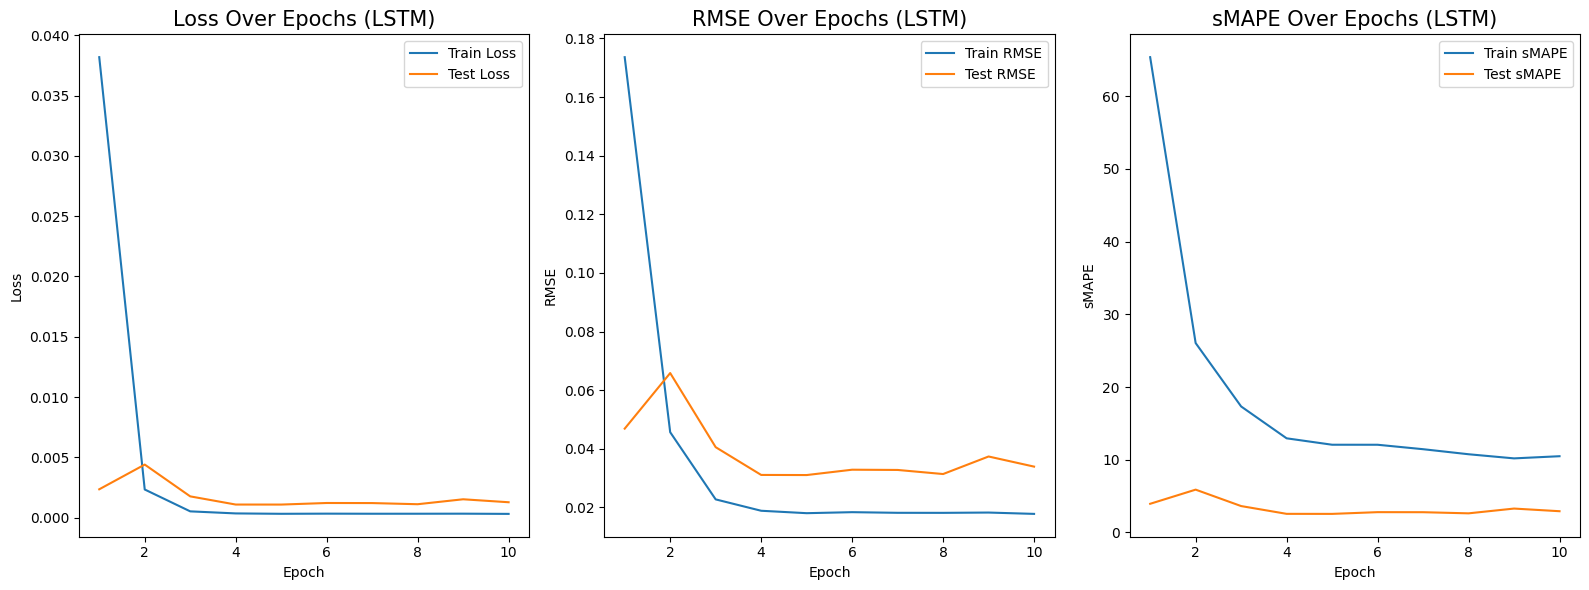

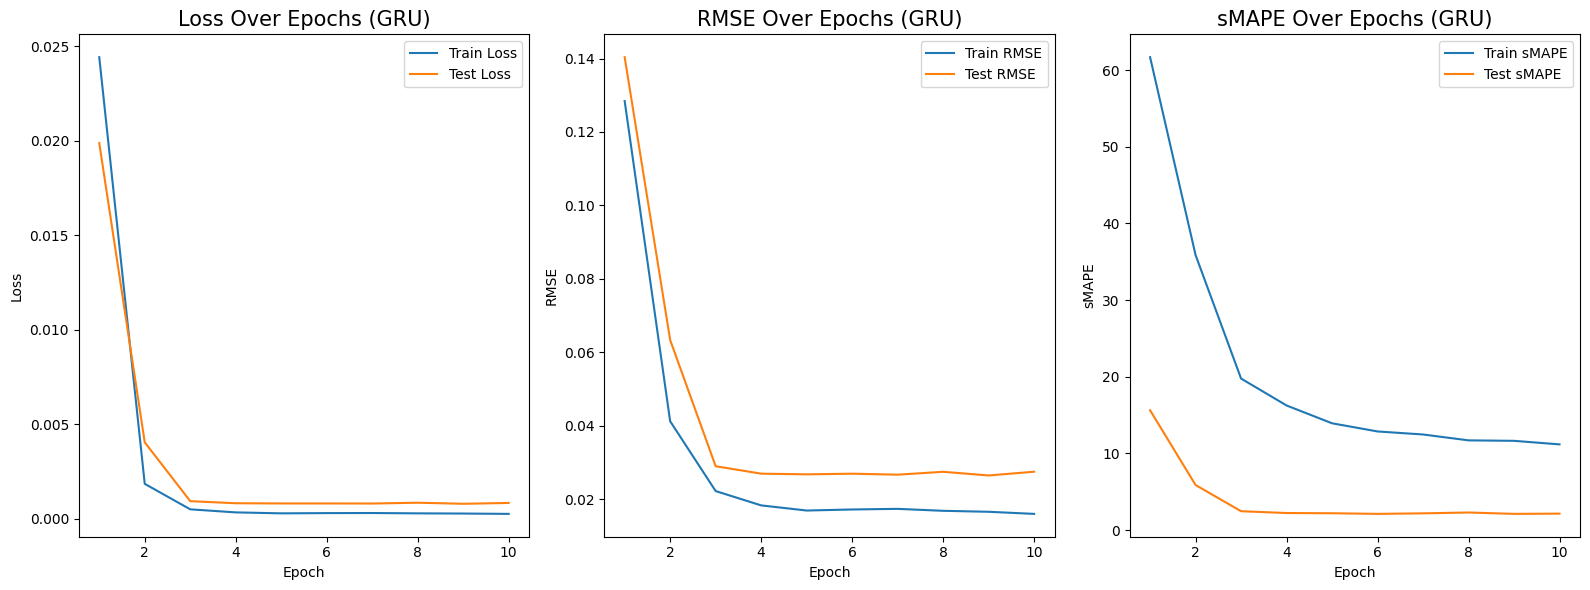

In [25]:
plot_performance("LSTM", EPOCHS, lstm_train_results, lstm_test_results)
plot_performance("GRU", EPOCHS, gru_train_results, gru_test_results)

### Predictions

In [ ]:
def make_predictions(
    model: torch.nn.Module,
    data_loader: DataLoader,
    device: torch.device,
) -> tuple[NDArray[np.float32], NDArray[np.float32]]:
    """
    Generate predictions and collect true targets from the DataLoader.

    Args:
        model: Trained PyTorch model for inference.
        data_loader: DataLoader containing the dataset to predict on.
        device: Device to run inference on.

    Returns:
        Tuple:
            all_predictions: NumPy array of all model predictions.
            all_targets: NumPy array of corresponding true targets.
    """
    all_predictions = []
    all_targets = []
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X = X.to(device)
            batch_size = X.size(0)
            h = model.init_hidden(batch_size)

            # Forward pass for predictions
            y_pred, h = model(X, h)
            all_predictions.append(y_pred.cpu())
            all_targets.append(y.cpu())
    all_predictions = torch.cat(all_predictions, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()
    return all_predictions, all_targets

In [27]:
lstm_all_preds, all_actual_y = make_predictions(lstm_model, test_dataloader, device)
lstm_all_preds_2d = lstm_all_preds.reshape(-1, OUTPUT_SIZE)
all_actual_y_2d = all_actual_y.reshape(-1, OUTPUT_SIZE)
lstm_all_preds_unscaled = target_scaler.inverse_transform(lstm_all_preds_2d)
all_actual_y_unscaled = target_scaler.inverse_transform(all_actual_y_2d)

gru_all_preds, _ = make_predictions(gru_model, test_dataloader, device)
gru_all_preds_2d = gru_all_preds.reshape(-1, OUTPUT_SIZE)
gru_all_preds_unscaled = target_scaler.inverse_transform(gru_all_preds_2d)

In [28]:
test_datetimes = df.index[-all_actual_y_unscaled.shape[0] :]

### Visualising Predictions

In [29]:
result_df = pd.DataFrame(
    {
        "datetime": test_datetimes,
        "actual_y": all_actual_y_unscaled.flatten(),
        "lstm": lstm_all_preds_unscaled.flatten(),
        "gru": gru_all_preds_unscaled.flatten(),
    }
)
result_df.set_index("datetime", inplace=True)

print(result_df.head())

              actual_y        lstm         gru
datetime                                      
2024-11-14  227.670807  220.615936  225.553375
2024-11-15  224.458557  220.852707  226.064728
2024-11-18  227.471283  221.014511  226.233215
2024-11-19  227.730652  221.328110  226.667267
2024-11-20  228.448914  221.804260  227.314056


In [30]:
def plot_predictions(results: pd.DataFrame, n_points: int, ticker: str) -> None:
    """
    Plot actual and predicted values from LSTM and GRU models.

    Args:
        results: DataFrame containing the columns 'actual_y', 'lstm', and 'gru'.
            The DataFrame index should correspond to the datetime or sequence order.
        n_points: Number of points (time steps) to plot from the results DataFrame.

    Notes:
        The function is intended for quick visual assessment of model performance over time.
        Ensure all values in `results` are unscaled and in physical units (e.g., MW, USD) for meaningful interpretation.
    """

    plt.figure(figsize=(12, 6))
    plt.plot(results["actual_y"][:n_points], label="Actual Values", color="blue")
    plt.plot(
        results["lstm"][:n_points],
        label="LSTM Predictions",
        color="red",
        linestyle="dashed",
    )
    plt.plot(
        results["gru"][:n_points],
        label="GRU Predictions",
        color="orange",
        linestyle="dashed",
    )
    plt.xlabel("Time Step")
    plt.ylabel("Close Price in USD ($)")
    plt.title(f"{ticker} - Actual vs Predicted Stock Price Over Time in USD ($)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

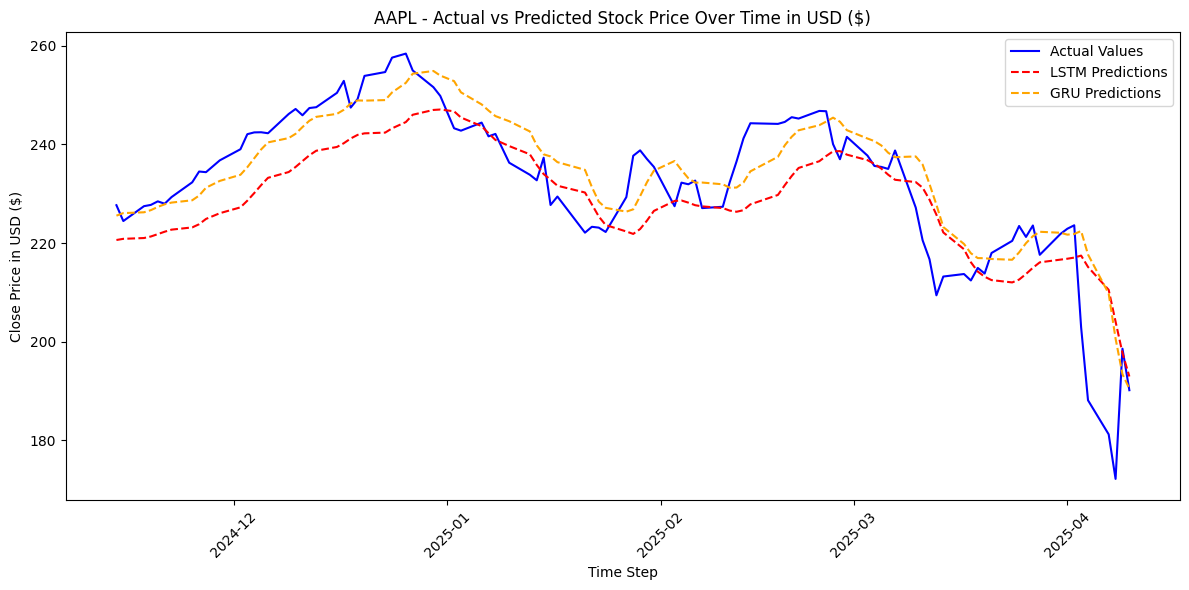

In [31]:
N_points = 100
plot_predictions(result_df, N_points, TICKER)

### Conclusion (Past Data)
After ten epochs of training, our GRU model produced slightly better evaluation metrics and executed faster compared to the LSTM model. The graph further illustrates that the GRU’s predictions track the actual stock price trends more closely than those of the LSTM. Nonetheless, these outcomes do not represent genuine future forecasts yet, since both training and testing are based on historical data. To predict unseen future values, Sequence-to-Sequence (Seq2Seq) models provide a robust and effective approach.

## 13. Predicting Future Values
### Sequence-to-Sequence (Seq2Seq)
Sequence-to-Sequence (Seq2Seq) is a neural network architecture designed to convert an input sequence into an output sequence, potentially of a different length. This architecture is widely used to transform one series of data into another, for example in machine translation, text summarisation, speech recognition, and time-series forecasting.

Seq2Seq architectures typically consist of two principal components:

- **Encoder**:
    - Processes the entire input sequence and condenses its information into a fixed-length context vector (or a series of hidden states). This vector captures the essential features of the input data.
- **Decoder**:
    - Utilises the encoded context to generate the output sequence step-by-step, predicting one element at a time. The decoder relies on both the context information and its own previously generated outputs to produce a coherent sequence.

Applied to the context of forecasting stock prices, a Seq2Seq model takes as input a historical sequence (e.g., the past 90 days of data) and produces as output multiple future values (e.g., the next five days), thereby enabling *multi-step time-series prediction*.

### DataLoaders for Seq2Seq
For the Seq2Seq architecture, the horizon parameter must be adjusted (here, `HORIZON_FUTURE = 5`) to forecast stock prices for the five consecutive days following today. This modification facilitates the model's direct multi-step prediction capability.

In [32]:
train_dataloader_s2s, test_dataloader_s2s, features_scaler_s2s, target_scaler_s2s = (
    prepare_dataloaders(
        df=df,
        seq_length=SEQUENCE_LENGTH,
        horizon=HORIZON_FUTURE,  # 5 consecutive days following today
        input_features=FEATURES,
        target_index=TARGET_INDEX,
        train_split=TRAIN_SPLIT_RATE,
        batch_size=BATCH_SIZE,
    )
)

Processing data...
n_samples: 2394
X.shape: (2300, 90, 5) | y.shape: (2300, 5, 1)
n_samples: 267
X.shape: (173, 90, 5) | y.shape: (173, 5, 1)
Dataloaders are generated!


### Training Seq2Seq Models

In [33]:
# LSTM Model
lstm_model_s2s = LSTMForecaster(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_size=OUTPUT_SIZE,
    n_layers=N_LAYERS,
    horizon=HORIZON_FUTURE,
)
lstm_optimiser_s2s = torch.optim.Adam(lstm_model_s2s.parameters(), lr=LEARNING_RATE)

print("Training LSTM...")
lstm_train_results_s2s, lstm_test_results_s2s = train_and_validate(
    lstm_model_s2s,
    train_dataloader_s2s,
    test_dataloader_s2s,
    loss_function,
    lstm_optimiser_s2s,
    device,
    EPOCHS,
)

Training LSTM...
Epoch: 1/10
Train Loss: 0.075381 | Train RMSE: 0.254477 | Train sMAPE: 89.504812
Test Loss: 0.040308 | Test RMSE: 0.200497 | Test sMAPE: 16.976782 

Epoch: 2/10
Train Loss: 0.008131 | Train RMSE: 0.083466 | Train sMAPE: 41.103880
Test Loss: 0.008846 | Test RMSE: 0.093610 | Test sMAPE: 9.454066 

Epoch: 3/10
Train Loss: 0.001468 | Train RMSE: 0.037058 | Train sMAPE: 20.705084
Test Loss: 0.002326 | Test RMSE: 0.045971 | Test sMAPE: 3.861803 

Epoch: 4/10
Train Loss: 0.000698 | Train RMSE: 0.026295 | Train sMAPE: 15.719964
Test Loss: 0.003900 | Test RMSE: 0.059748 | Test sMAPE: 5.475234 

Epoch: 5/10
Train Loss: 0.000556 | Train RMSE: 0.023503 | Train sMAPE: 13.200478
Test Loss: 0.003082 | Test RMSE: 0.052208 | Test sMAPE: 4.647767 

Epoch: 6/10
Train Loss: 0.000539 | Train RMSE: 0.023148 | Train sMAPE: 12.820062
Test Loss: 0.004128 | Test RMSE: 0.061649 | Test sMAPE: 5.681714 

Epoch: 7/10
Train Loss: 0.000539 | Train RMSE: 0.023145 | Train sMAPE: 12.517068
Test Loss: 0.

In [34]:
# GRU Model
gru_model_s2s = GRUForecaster(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_size=OUTPUT_SIZE,
    n_layers=N_LAYERS,
    horizon=HORIZON_FUTURE,
)
gru_optimiser_s2s = torch.optim.Adam(gru_model_s2s.parameters(), lr=LEARNING_RATE)

print("Training GRU...")
gru_train_results_s2s, gru_test_results_s2s = train_and_validate(
    gru_model_s2s,
    train_dataloader_s2s,
    test_dataloader_s2s,
    loss_function,
    gru_optimiser_s2s,
    device,
    EPOCHS,
)

Training GRU...
Epoch: 1/10
Train Loss: 0.038144 | Train RMSE: 0.164708 | Train sMAPE: 68.508812
Test Loss: 0.008792 | Test RMSE: 0.093505 | Test sMAPE: 8.607116 

Epoch: 2/10
Train Loss: 0.002241 | Train RMSE: 0.045348 | Train sMAPE: 37.660561
Test Loss: 0.002714 | Test RMSE: 0.050466 | Test sMAPE: 4.331568 

Epoch: 3/10
Train Loss: 0.000691 | Train RMSE: 0.026135 | Train sMAPE: 22.127202
Test Loss: 0.001611 | Test RMSE: 0.037489 | Test sMAPE: 3.072795 

Epoch: 4/10
Train Loss: 0.000497 | Train RMSE: 0.022214 | Train sMAPE: 12.967121
Test Loss: 0.001518 | Test RMSE: 0.036007 | Test sMAPE: 2.915278 

Epoch: 5/10
Train Loss: 0.000460 | Train RMSE: 0.021404 | Train sMAPE: 12.728927
Test Loss: 0.001524 | Test RMSE: 0.035986 | Test sMAPE: 2.982735 

Epoch: 6/10
Train Loss: 0.000496 | Train RMSE: 0.022208 | Train sMAPE: 12.177327
Test Loss: 0.001516 | Test RMSE: 0.035858 | Test sMAPE: 2.921625 

Epoch: 7/10
Train Loss: 0.000468 | Train RMSE: 0.021508 | Train sMAPE: 11.588162
Test Loss: 0.00

In [35]:
def predict_next_days(
    model: torch.nn.Module,
    recent_sequence: NDArray[np.float64],
    device: torch.device,
    features_scaler: MinMaxScaler,
    target_scaler: MinMaxScaler,
) -> NDArray[np.float32]:
    """
    Predict multiple future values from the most recent input sequence using a trained seq2seq model.

    Args:
        model: Trained PyTorch sequence-to-sequence forecasting model
            (e.g., LSTM or GRU).
        recent_sequence: Raw, unscaled input sequence of shape (sequence_length, n_features),
            corresponding to the most recent window prior to prediction.
        device: Device (CPU or GPU) used for inference.
        features_scaler: Fitted scaler used to normalise input features (e.g., MinMaxScaler).
        target_scaler: Fitted scaler used to inverse-transform model outputs to original scale.

    Returns:
        Array of predicted values for the next `horizon` time steps, in the original target scale. Shape is (horizon,).
    """
    model.eval()
    input_seq = features_scaler.transform(recent_sequence)
    input_seq = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        output, _ = model(input_seq)
    # output: shape (1, horizon, 1)
    pred_scaled = output.cpu().numpy().reshape(-1, 1)  # (horizon, 1)
    preds = target_scaler.inverse_transform(pred_scaled)
    return preds.flatten()


In [36]:
# ! Predict the next 5 trading days from the most recent window of data
recent_seq = df.values[-SEQUENCE_LENGTH:]  # shape: (seq_length, n_features)

next_days_lstm_pred = predict_next_days(
    lstm_model_s2s, recent_seq, device, features_scaler_s2s, target_scaler_s2s
)
next_days_gru_pred = predict_next_days(
    gru_model_s2s, recent_seq, device, features_scaler_s2s, target_scaler_s2s
)

# Output the predictions
prediction_dates = pd.date_range(
    df.index[-1] + pd.Timedelta(days=1), periods=HORIZON_FUTURE, freq="B"
)
result = pd.DataFrame(
    {"LSTM_Pred": next_days_lstm_pred, "GRU_Pred": next_days_gru_pred},
    index=prediction_dates,
)
print("\n5-Day Ahead Forecast ('Close'):")
print(result)


5-Day Ahead Forecast ('Close'):
             LSTM_Pred    GRU_Pred
2025-08-04  207.554581  210.197723
2025-08-05  207.414490  210.770020
2025-08-06  206.341339  211.444717
2025-08-07  207.546677  211.063110
2025-08-08  207.334839  211.058411


### Plotting Future Predictions

In [37]:
def plot_future_predictions(
    df: pd.DataFrame,
    prediction_dates: pd.DatetimeIndex,
    lstm_preds: NDArray[np.float32],
    gru_preds: NDArray[np.float32],
    ticker: str,
) -> None:
    """
    Plot the last 10 actual 'Close' values and next 5 forecasted values
    from LSTM and GRU models, including transition lines and a vertical line for today.

    Args:
        df: DataFrame containing the historical stock data, including 'Close' prices.
        prediction_dates: Dates corresponding to the predicted (future) values.
        lstm_preds: Predicted 'Close' prices from the LSTM model (shape: (n_forecast,)).
        gru_preds: Predicted 'Close' prices from the GRU model (shape: (n_forecast,)).
        ticker: Stock ticker symbol (used in plot title).

    Returns:
        None: This function displays the matplotlib plot and does not return a value.
    """
    last_10_actual = df["Close"].iloc[-10:]
    last_10_dates = df.index[-10:]

    plt.figure(figsize=(12, 6))
    plt.plot(last_10_dates, last_10_actual, "-o", label="Actual Values", color="blue")
    plt.plot(prediction_dates, lstm_preds, "-o", label="LSTM Predictions", color="red")
    plt.plot(prediction_dates, gru_preds, "-o", label="GRU Predictions", color="orange")

    # Connect last actual point to first forecast points with dashed lines
    plt.plot(
        [last_10_dates[-1], prediction_dates[0]],
        [last_10_actual.iloc[-1], lstm_preds[0]],
        "k--",
        linewidth=1,
    )
    plt.plot(
        [last_10_dates[-1], prediction_dates[0]],
        [last_10_actual.iloc[-1], gru_preds[0]],
        "k--",
        linewidth=1,
    )

    # Draw a vertical dotted line for today
    today = pd.Timestamp(date.today())
    plt.axvline(today, color="red", linestyle="--", label="Today")

    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.title(f"{ticker} - Last 10 Actual Values and Next 5 Day Predictions")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


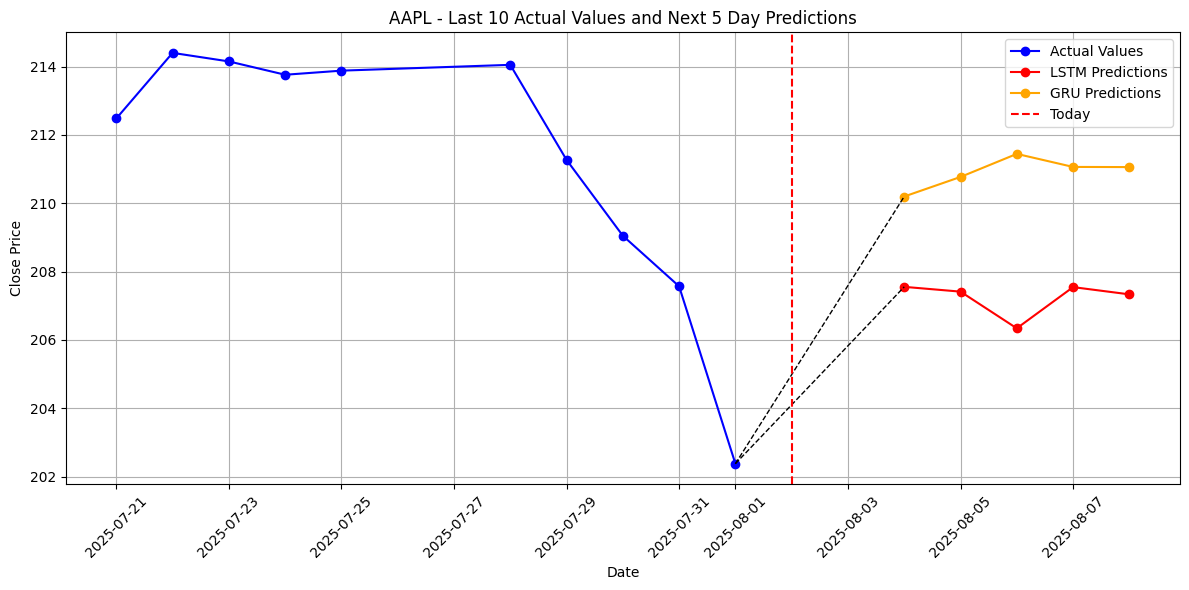

In [38]:
plot_future_predictions(
    df, prediction_dates, next_days_lstm_pred, next_days_gru_pred, TICKER
)

### Conclusion (Future Prediction)
As demonstrated in the graph above, both the LSTM and GRU models successfully generated predictions on unseen (future) data. Time-series forecasting models rely on *lags* (previous time steps) to predict sequential values. In financial contexts, many technical indicators and metrics are considered lagging indicators because they become visible only after price movements or economic changes have occurred. Consequently, these models primarily extrapolate from historical trends rather than anticipating unprecedented market events or new information.

It is important to emphasise that stock market prices are largely influenced by a multitude of factors beyond historical patterns, such as macroeconomic conditions, geopolitical events, investor sentiment, and unexpected shocks. Therefore, forecasts derived solely from past data and RNN-based models should **NOT** be used as standalone financial decision-support tools. Instead, they serve primarily as illustrative examples of how recurrent neural network architectures can be applied to sequential data and time-series prediction problems.

## 14. References

1. Benson, Bernard & Pan, W. & Prasad, Avijeet & Gary, G. & Hu, Q.. (2020). *Forecasting Solar Cycle 25 Using Deep Neural Networks.* Solar Physics. 295. 10.1007/s11207-020-01634-y. <br>
https://www.researchgate.net/publication/341502672_Forecasting_Solar_Cycle_25_Using_Deep_Neural_Networks

1. Coralogic Team. (2023). *A Comprehensive Guide to Mean Absolute Percentage Error (MAPE)*.<br>
https://coralogix.com/ai-blog/a-comprehensive-guide-to-mean-absolute-percentage-error-mape/

1. Encode. (2023). *Time Series Predictions with RNNs*.<br>
https://encord.com/blog/time-series-predictions-with-recurrent-neural-networks/#:~:text=To%20assess%20the%20performance%20of,Absolute%20Percentage%20Error%20(MAPE).

1. GeeksforGeeks. (2025). *Gated Recurrent Unit Networks*.<br>
https://www.geeksforgeeks.org/machine-learning/gated-recurrent-unit-networks/

1. GeeksforGeeks. (2025). *What is Lag in Time Series Forecasting*.<br>
https://www.geeksforgeeks.org/machine-learning/what-is-lag-in-time-series-forecasting/

1. GeeksforGeeks. (2025). *What is LSTM - Long Short Term Memory?*<br>
https://www.geeksforgeeks.org/deep-learning/deep-learning-introduction-to-long-short-term-memory/

1. GeeksforGeeks. (2025). *seq2seq Model*.<br>
https://www.geeksforgeeks.org/machine-learning/seq2seq-model-in-machine-learning/

1. Github - Issues. (2025). *Memory Leak in MPS Backend During LSTM Iterations (Out of Memory Error)*.<br>
https://github.com/pytorch/pytorch/issues/145374

1. Github - Issues. (2023). *MPS backend produces bad training results in comparison to other backends*.<br>
https://github.com/pytorch/pytorch/issues/92615

1. Github - Issues. (2023). *Training results from using MPS backend are poor compared to CPU and CUDA*.<br>
https://github.com/pytorch/pytorch/issues/109457

1. THE INVESTOPEDIA TEAM. (2023). *Lagging Indicator: Economic, Business, and Technical*. <br>
https://www.investopedia.com/terms/l/laggingindicator.asp